# Convolutional Neural Networks

For this homework you will train a CNN on the Hymenoptera dataset that you can download from here:

- https://download.pytorch.org/tutorial/hymenoptera_data.zip

You will code any CNN architecture that you want for this, using pytorch and/or pytorch-lightning (you can use only pytorch is you want)

## Load the dataset

**QUESTION.** Load the dataset into two dataloaders, one from training and the other for validation.

- You can use `torchvision.datasets.ImageFolder` and pass it to `DataLoader` for this, have a look at the documentation
- In the transformations, you should resize the images to make things faster (using the size of CIFAR-10's images for instance), and use some data augmentation (only for the training dataloader, of course) 

Sofia AIT AHCENE && Duc Nguyen DUONG M2 MIDS

In [ ]:
%%capture
!wget "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
!unzip  /content/hymenoptera_data

In [ ]:
#!rm -R hymenoptera_data


In [ ]:
%%capture
!pip install pytorch-lightning
!pip install scikit-plot

In [ ]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import os

from collections import defaultdict
import pandas as pd
from statistics import mean 
from matplotlib import pyplot as plt

import pytorch_lightning as pl

from sklearn.metrics import confusion_matrix
import scikitplot as skplt

In [ ]:
# Check PyTorch versions
print(torch.__version__)
print(torchvision.__version__)

1.8.0+cu101
0.9.0+cu101


The batch size has been fixed after evaluating the performance of the models with different values.

In [ ]:
batch_size = 16
num_workers = 2
dir = "hymenoptera_data"

In order to have a better performance, we apply some data augmentation on the datasets.

On the training dataset, we apply:
*   resize of a random scaled crop of the images
*   randomly horizontal flip images
*   tensor normalization

On the validation dataset, we apply:
*   resize of the images
*   crop the images at the center
*   tensor normalization

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
train_dataset = datasets.ImageFolder(os.path.join(dir,'train'), data_transforms['train'])
valid_dataset = datasets.ImageFolder(os.path.join(dir,'val'), data_transforms['val'])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, num_workers=num_workers)

In [ ]:
class_names = train_dataset.classes

In [ ]:
class_names

['ants', 'bees']

In [ ]:
print("train dataset : {}".format(len(train_dataset)))
print("valid dataset : {}".format(len(valid_dataset)))

train dataset : 244
valid dataset : 153


**QUESTION.** Display some images and their associated labels. You should see images of bees and ants :)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


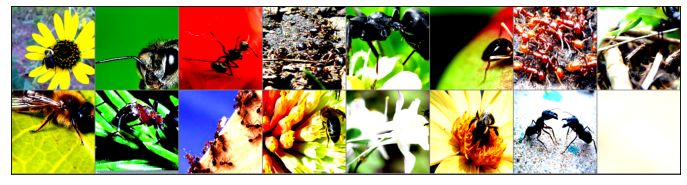

 bees  bees  ants  ants  ants  ants  ants  ants  bees  ants  ants  bees  bees  bees  ants  ants


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_images(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks(())
    plt.yticks(())
    plt.show()
    
dataiter = iter(train_dataloader)
images, labels = dataiter.next()
show_images(torchvision.utils.make_grid(images))
print(' '.join('%5s' % class_names[labels[j]] for j in range(batch_size)))

## Neural net architecture

You are free to define any kind of convolutional neural network that you think is reasonable for today's problem.
Remember that convolutional neural networks are usually a combination of the following building blocks:

  * Convolutional layers
  * Pooling layers
  * Linear layers
  
It is your task today to arrange these components into a reasonable architecture.

In [ ]:
# Inherit from LightningModule is you use pytorch-lightning, and you'll need to code some more methods
class ConvNet(pl.LightningModule):

    def __init__(self,name):

        super(ConvNet, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Dropout2d(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d()
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=41472, out_features=2048),
            nn.ReLU(),
            nn.Dropout2d(0.25),
            nn.Linear(in_features=2048, out_features=2)
        )
        self.name = name

        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = pl.metrics.Accuracy()

        self.valid_acc = []
        self.valid_loss = []

        self.train_acc = []
        self.train_loss = []


    def forward(self, x):
        features = self.encoder(x)
        features = features.view(features.size(0),-1)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {"loss":loss,'acc':acc}

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def _epoch_util(self,outputs,epoch_type):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['acc'] for x in outputs]).mean()
        if epoch_type == 'train':
            self.train_acc.append(avg_acc)
            self.train_loss.append(avg_loss)
        if epoch_type == 'valid':
            self.valid_acc.append(avg_acc)
            self.valid_loss.append(avg_loss)

    def validation_epoch_end(self,outputs):
        self._epoch_util(outputs,'valid')
    def training_epoch_end(self,outputs):
        self._epoch_util(outputs,'train')

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)

In [ ]:
net1 = ConvNet("CustomNet")
x = torch.rand(3,3,224,224)
out = net1(x)

In [ ]:
out

tensor([[-0.2946, -0.1015],
        [ 0.1973, -0.1663],
        [ 0.3878,  0.5348]], grad_fn=<AddmmBackward>)

## Use fine-tuning and transfer learning

You might have noticed that training a CNN from scratch can be very slow, hard, painful, and that the overall performance might not be satisfying. 

**QUESTION.** To overcome this, use a pre-trained network and fine-tune it on the Hymenoptera dataset.
You are free to choose any pre-trained model that the PyTorch library offers evaluate and compare its performance to the CNN you have built yourself.

We will try to improve the performance by using 4 pre-trained networks : resnet18, resnet50, vgg13_bn and google net. Then, we will compare their performance.

In [ ]:
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau

class TLNet(pl.LightningModule):

    def __init__(self, name):

        super(TLNet, self).__init__()
        self.name = name
        if name == "vgg13_bn":
            feature_extractor = models.vgg13_bn(pretrained=True)
            self.feature_extractor = feature_extractor.features
            self.classifier = feature_extractor.classifier
            self.in_features = self.classifier[6].in_features
        else:
            if name == "resnet50":
                feature_extractor = models.resnet50(pretrained=True)
                self.in_features=feature_extractor.fc.in_features
            if name == "resnet18":
                feature_extractor = models.resnet18(pretrained=True)
                self.in_features=feature_extractor.fc.in_features
            if name == "googlenet":
                feature_extractor = models.googlenet(pretrained=True)
                self.in_features=feature_extractor.fc.in_features
            # Delete the last fully-connected layer
            layers = list(feature_extractor.children())[:-1]
            self.feature_extractor = nn.Sequential(*layers)

            self.classifier = nn.Sequential(
                nn.Linear(in_features=self.in_features, out_features=1024),
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(in_features=1024, out_features=2)
            )


        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = pl.metrics.Accuracy()
        self.learning_rate = 0.001
        self.moment = 0.9

        self.valid_acc = []
        self.valid_loss = []

        self.train_acc = []
        self.train_loss = []


    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.reshape(features.size(0), -1)
        logits = self.classifier(features)
        return logits

    def _step_util(self, batch, batch_idx, step_type):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.accuracy(F.softmax(logits, dim=1), y)
        self.log(step_type + "_loss", loss, on_step=True, on_epoch=True, prog_bar=False, logger=True)
        self.log(step_type + "_acc", acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return {"loss":loss,'acc':acc}

    def training_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "train")

    def validation_step(self, batch, batch_idx):
        return self._step_util(batch, batch_idx, "valid")

    def _epoch_util(self,outputs,epoch_type):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['acc'] for x in outputs]).mean()
        if epoch_type == 'train':
            self.train_acc.append(avg_acc)
            self.train_loss.append(avg_loss)
        if epoch_type == 'valid':
            self.valid_acc.append(avg_acc)
            self.valid_loss.append(avg_loss)

    def validation_epoch_end(self,outputs):
        self._epoch_util(outputs,'valid')
    def training_epoch_end(self,outputs):
        self._epoch_util(outputs,'train')

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(),lr = self.learning_rate, momentum = self.moment, nesterov = True)
        lr_scheduler = ReduceLROnPlateau(optimizer,factor = 0.5,patience = 3, verbose = True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': lr_scheduler,
            'monitor': 'valid_loss_epoch'
        }

## Training loop and checks

**QUESTION**. Code the training loop (specify the loss, etc.). Check that everything is fine, that the forward pass works and that training on a very small subset of the data works as well. Add the callbacks that you want, and prepare the logging tools that you want to use (such as tensorboard, or anything you want to use.

In [ ]:
customNet = ConvNet('custom_net')
resnet50 = TLNet('resnet50')
resnet18 = TLNet('resnet18')
vgg13_bn = TLNet('vgg13_bn')
googlenet = TLNet('googlenet')


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Downloading: "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth" to /root/.cache/torch/hub/checkpoints/vgg13_bn-abd245e5.pth


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


In [ ]:
models_list = [customNet,resnet50,resnet18,vgg13_bn,googlenet]

In [ ]:
num_epochs = 15

In [ ]:
for model in models_list:
    trainer = pl.Trainer(gpus=1, fast_dev_run=True)
    trainer.fit(model, train_dataloader=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).

  | Name       | Type             | Params
------------------------------------------------
0 | encoder    | Sequential       | 6.0 K 
1 | classifier | Sequential       | 84.9 M
2 | criterion  | CrossEntropyLoss | 0     
3 | accuracy   | Accuracy         | 0     
------------------------------------------------
84.9 M    Trainable params
0         Non-trainable params
84.9 M    Total params
339.787   Total estimated model params size (MB)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).

  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 23.5 M
1 | classifier        | Sequential       | 2.1 M 
2 | criterion         | CrossEntropyLoss | 0     
3 | accuracy          | Accuracy         | 0     
-------------------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.433   Total estimated model params size (MB)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).

  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 11.2 M
1 | classifier        | Sequential       | 527 K 
2 | criterion         | CrossEntropyLoss | 0     
3 | accuracy          | Accuracy         | 0     
-------------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.815    Total estimated model params size (MB)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).



  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 9.4 M 
1 | classifier        | Sequential       | 123 M 
2 | criterion         | CrossEntropyLoss | 0     
3 | accuracy          | Accuracy         | 0     
-------------------------------------------------------
133 M     Trainable params
0         Non-trainable params
133 M     Total params
532.215   Total estimated model params size (MB)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Running in fast_dev_run mode: will run a full train, val and test loop using 1 batch(es).

  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 5.6 M 
1 | classifier        | Sequential       | 1.1 M 
2 | criterion         | CrossEntropyLoss | 0     
3 | accuracy          | Accuracy         | 0     
-------------------------------------------------------
6.7 M     Trainable params
0         Non-trainable params
6.7 M     Total params
26.606    Total estimated model params size (MB)


In [ ]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
for model in models_list:
    early_stop_callback = EarlyStopping(
        monitor='valid_acc_epoch',
        patience=10,
        mode='max'
    )
    trainer = pl.Trainer(gpus=1,max_epochs = num_epochs,callbacks=[early_stop_callback])
    trainer.fit(model, train_dataloader=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name       | Type             | Params
------------------------------------------------
0 | encoder    | Sequential       | 6.0 K 
1 | classifier | Sequential       | 84.9 M
2 | criterion  | CrossEntropyLoss | 0     
3 | accuracy   | Accuracy         | 0     
------------------------------------------------
84.9 M    Trainable params
0         Non-trainable params
84.9 M    Total params
339.787   Total estimated model params size (MB)


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 23.5 M
1 | classifier        | Sequential       | 2.1 M 
2 | criterion         | CrossEntropyLoss | 0     
3 | accuracy          | Accuracy         | 0     
-------------------------------------------------------
25.6 M    Trainable params
0         Non-trainable params
25.6 M    Total params
102.433   Total estimated model params size (MB)


Epoch    11: reducing learning rate of group 0 to 5.0000e-04.


Epoch    15: reducing learning rate of group 0 to 2.5000e-04.


GPU available: True, used: True
TPU available: None, using: 0 TPU cores



  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 11.2 M
1 | classifier        | Sequential       | 527 K 
2 | criterion         | CrossEntropyLoss | 0     
3 | accuracy          | Accuracy         | 0     
-------------------------------------------------------
11.7 M    Trainable params
0         Non-trainable params
11.7 M    Total params
46.815    Total estimated model params size (MB)


Epoch    14: reducing learning rate of group 0 to 5.0000e-04.


GPU available: True, used: True
TPU available: None, using: 0 TPU cores



  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 9.4 M 
1 | classifier        | Sequential       | 123 M 
2 | criterion         | CrossEntropyLoss | 0     
3 | accuracy          | Accuracy         | 0     
-------------------------------------------------------
133 M     Trainable params
0         Non-trainable params
133 M     Total params
532.215   Total estimated model params size (MB)


Epoch    13: reducing learning rate of group 0 to 5.0000e-04.


GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name              | Type             | Params
-------------------------------------------------------
0 | feature_extractor | Sequential       | 5.6 M 
1 | classifier        | Sequential       | 1.1 M 
2 | criterion         | CrossEntropyLoss | 0     
3 | accuracy          | Accuracy         | 0     
-------------------------------------------------------
6.7 M     Trainable params
0         Non-trainable params
6.7 M     Total params
26.606    Total estimated model params size (MB)


## Measure the performance of you model

Measure the performance of your model, and display some things (such as confusion matrix, ROC or AUC curves).
Compare several architectures, put your results in an easy to interpret pandas dataframe.

In [ ]:
def plot_history_acc(models):
    fig, axs = plt.subplots(1,2,sharey=True,figsize=(18,5))
    for model in models:
            axs[0].plot(range(len(model.train_acc)), model.train_acc, lw=2, label= model.name)
            axs[1].plot(range(len(model.valid_acc)), model.valid_acc, lw=2, label= model.name)
    axs[0].set_title("Training accuracy", fontsize=16)
    axs[1].set_title("Validation accuracy", fontsize=16)
    for ax in axs:
        ax.legend(fontsize=14)
        ax.set_xlabel('Epoch', fontsize=14)
        ax.set_ylabel('Accuracy', fontsize=14)

In [ ]:
def plot_history_loss(models):
    fig, axs = plt.subplots(1,2,sharey=True,figsize=(18,5))
    for model in models:
            axs[0].plot(range(len(model.train_loss)), model.train_loss, lw=2, label= model.name)
            axs[1].plot(range(len(model.valid_loss)), model.valid_loss, lw=2, label= model.name)
    axs[0].set_title("Training Loss", fontsize=16)
    axs[1].set_title("Validation Loss", fontsize=16)
    for ax in axs:
        ax.legend(fontsize=14)
        ax.set_yscale('log')
        ax.set_xlabel('Epoch', fontsize=14)
        ax.set_ylabel('Loss', fontsize=14)

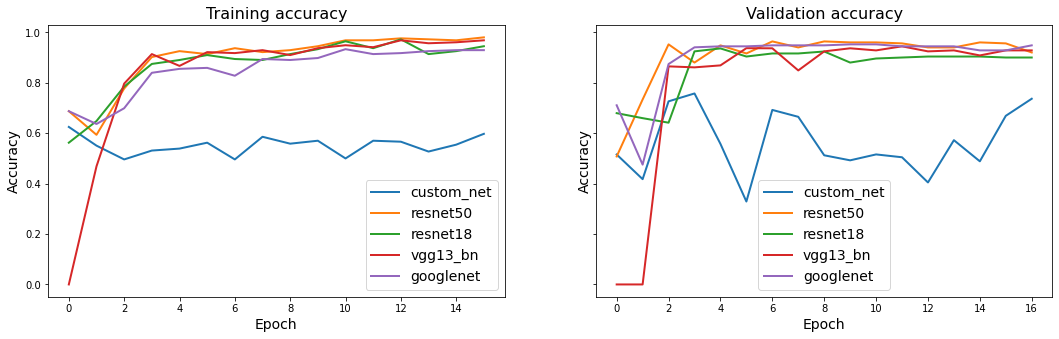

In [ ]:
plot_history_acc(models_list)

We can see here, pre-trained models outperform our little custom model. We can achieve more than 90% accuracy with all pre-trained models resnet50, resnet18, vgg13_bn, googlenet. On the other hand, our custom model seems to perform very poorly (~ 50-60% accuracy)

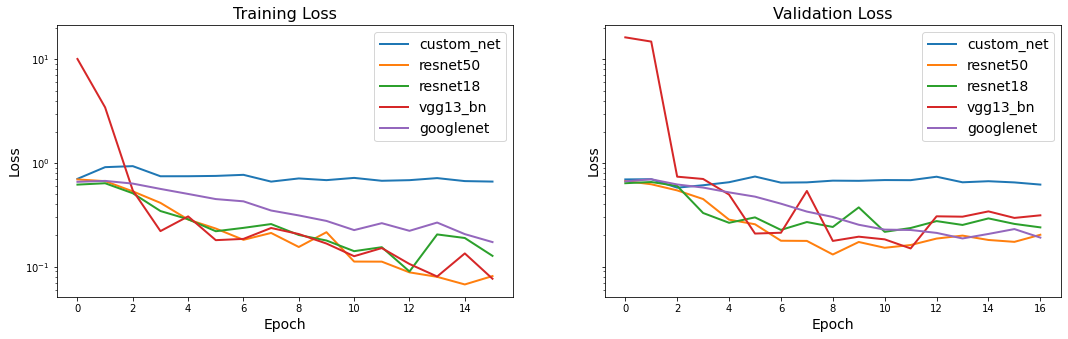

In [ ]:
plot_history_loss(models_list)

Once again, if we look at the loss curves, our custom model is still out-performed by pre-trained models.

In [ ]:
list_acc = []

In [ ]:
def get_acc(models):
    list_acc = []
    for i in range(len(models)):
        list_acc.append(dict())
        list_acc[i]['model'] = models[i].name
        list_acc[i]['train_acc'] = models[i].train_acc[-1]
        list_acc[i]['valid_acc'] = models[i].valid_acc[-1]
    return list_acc

In [ ]:
list_acc = get_acc(models_list)

In [ ]:
from prettytable import PrettyTable
t  = PrettyTable(["Model","Train_acc","Valid_acc"])
for item in list_acc:
  t.add_row([item['model'],round(item['train_acc'].cpu().detach().item(),3),round(item['valid_acc'].cpu().detach().item(),3)])
print(t)

+------------+-----------+-----------+
|   Model    | Train_acc | Valid_acc |
+------------+-----------+-----------+
| custom_net |   0.598   |   0.737   |
|  resnet50  |    0.98   |    0.92   |
|  resnet18  |   0.945   |    0.9    |
|  vgg13_bn  |   0.969   |   0.929   |
| googlenet  |    0.93   |   0.949   |
+------------+-----------+-----------+


Here, we can see that resnet50 is a little bit overfitted. 

Resnet50 is better than resnet18 since it has a deeper architecture.

We are surprised that googlenet performs that well with an accuracy of ~ 95%.

Since vgg13_bn have the most complex architecture, we were waiting for better performance, but we just trained the model for 15 epochs. Maybe if we trained for some more epochs, it becomes the best.